<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_04_14_jax_speed_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# JAX Speed Test

## Acknowledgment:
- [Just In Time Compilation with JAX](https://jax.readthedocs.io/en/latest/jax-101/02-jitting.html#main-content)
- [🔪 JAX - The Sharp Bits 🔪](https://jax.readthedocs.io/en/latest/notebooks/Common_Gotchas_in_JAX.html#pure-functions)
- I borrowed the CNN architecture from [FLAX examples](https://github.com/google/flax/blob/main/examples/mnist/train.py).
- I borrowed the cifar10 preprocessing code from this github [repository](https://github.com/satojkovic/vit-jax-flax/tree/main) by satojkovic.

## References:
```bibtex
@software{jax2018github,
 author  = {James Bradbury and Roy Frostig and Peter Hawkins and Matthew James Johnson and Chris Leary and Dougal Maclaurin and George Necula and Adam Paszke and Jake Vander{P}las and Skye Wanderman-{M}ilne and Qiao Zhang},
 title  = {{JAX}: composable transformations of {P}ython+{N}um{P}y programs},
 url    = {http://github.com/google/jax},
 version = {0.3.13},
 year   = {2018},
}
```

## Import libraries

In [ ]:
# Standard libraries
import numpy as np
import seaborn as sns
import pandas as pd
import torch
from torch.utils import data

# Plotting libraries
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import cm
from IPython.display import Javascript  # Restrict height of output cell.

# jax
import jax
import jax.numpy as jnp
from jax.tree_util import tree_map
import flax
from flax import linen as nn
from flax.training import train_state
import optax

#torchvision
import torchvision
import torchvision.transforms as transforms

# scikit-learn
from sklearn.datasets import (make_blobs, make_circles)
from sklearn.model_selection import train_test_split

In [ ]:
plt.style.use('dark_background')
plot_colors = cm.tab10.colors
timing_list = []

In [ ]:
IMAGE_SIZE = 32
BATCH_SIZE = 128
DATA_MEANS = np.array([0.49139968, 0.48215841, 0.44653091])
DATA_STD = np.array([0.24703223, 0.24348513, 0.26158784])
CROP_SCALES = (0.8, 1.0)
CROP_RATIO = (0.9, 1.1)
SEED = 42

## Toy Dataset
Here we create a two dimensional toy dataset using `data.Dataset` class. Creating a `Dataset` instance will help us creating a `Dataloader` for training and testing.

In [ ]:
class ToyDataset(data.Dataset):

  def __init__(self, size, seed):
    super().__init__()
    self.size = size
    self.np_rng = np.random.RandomState(seed=seed)
    self.make_nested_classes()

  def make_nested_classes(self):
    X, y = make_blobs(n_samples=int(self.size*0.2), n_features=2, centers=2, cluster_std=1.9, random_state=SEED)
    X1, y1 = make_circles(n_samples=(int(self.size*0.6), int(self.size*0.2)), noise=0.05, factor=0.1, random_state=SEED)
    # increase the radius
    X1 = X1*3
    # move along the x-axis
    X1[:,0] = X1[:,0]+2.5
    # move along the y-axis
    X1[:,1] = X1[:,1]-7

    X = np.concatenate((X, X1), axis=0)
    y = np.concatenate((y, y1), axis=0)

    self.data = X
    self.label = y

  def __len__(self):
    return self.size

  def __getitem__(self, idx):
    data_point = self.data[idx]
    data_label = self.label[idx]
    return data_point, data_label

In [ ]:
dataset = ToyDataset(size=10000, seed=SEED)
dataset

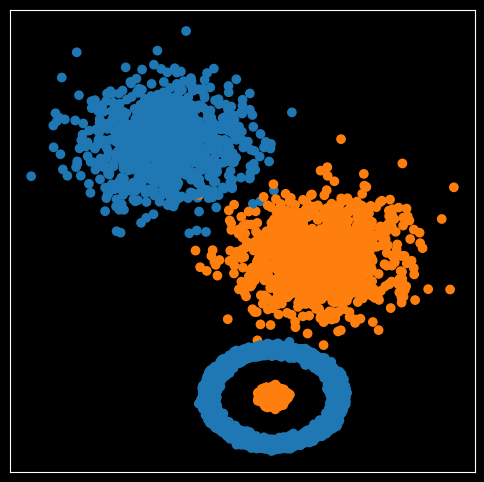

In [ ]:
fig, ax = plt.subplots(figsize=(6,6))
ax.scatter(dataset.data[:,0], dataset.data[:,1], marker='o', color=np.array(plot_colors)[dataset.label])

ax.tick_params(axis='both',which='both',bottom=False,top=False,left=False,right=False,
            labelbottom=False,labeltop=False,labelleft=False,labelright=False);
ax.set(xlabel=None, ylabel=None)
plt.show()

## Train/Test splits
We split the dataset to 80% for training and 20% for testing using `data.random_split`. Then we package these splits in dataloaders. We specified `collate_fn=numpy_collate` to create numpy batches instead of torch tensor batches, which is the default option.

In [ ]:
train_size = int(0.8 * len(dataset))
test_size = len(dataset) - train_size
train_dataset, test_dataset = data.random_split(dataset, [train_size, test_size], generator=torch.Generator().manual_seed(SEED))

In [ ]:
# A helper function that converts batches into numpy arrays instead of the default option which is torch tensors
def numpy_collate(batch):
  if isinstance(batch[0], np.ndarray):
    return np.stack(batch)
  elif isinstance(batch[0], (tuple, list)):
    transposed = zip(*batch)
    return [numpy_collate(samples) for samples in transposed]
  else:
    return np.array(batch)

In [ ]:
train_data_loader = data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=numpy_collate)
test_data_loader = data.DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=numpy_collate)

## MLP

The `MLPClassifier` creates a neural net instance where the hidden layers are specified by the user. It applies `relu` function to the hidden layer output and applies `log_softmax` to the output. We initialize the `MLPClassifier` to one hidden layer with ten neurons.

In [ ]:
class MLPClassifier(nn.Module):
    hidden_layers: int
    hidden_dim: int
    n_classes: int

    @nn.compact
    def __call__(self, x):
        for layer in range(self.hidden_layers):
            x = nn.Dense(self.hidden_dim)(x)
            x = nn.relu(x)
        x = nn.Dense(self.n_classes)(x)
        x = nn.log_softmax(x)
        return x

In [ ]:
model = MLPClassifier(hidden_layers=1, hidden_dim=10, n_classes=2)
print(model)

MLPClassifier(
    # attributes
    hidden_layers = 1
    hidden_dim = 10
    n_classes = 2
)


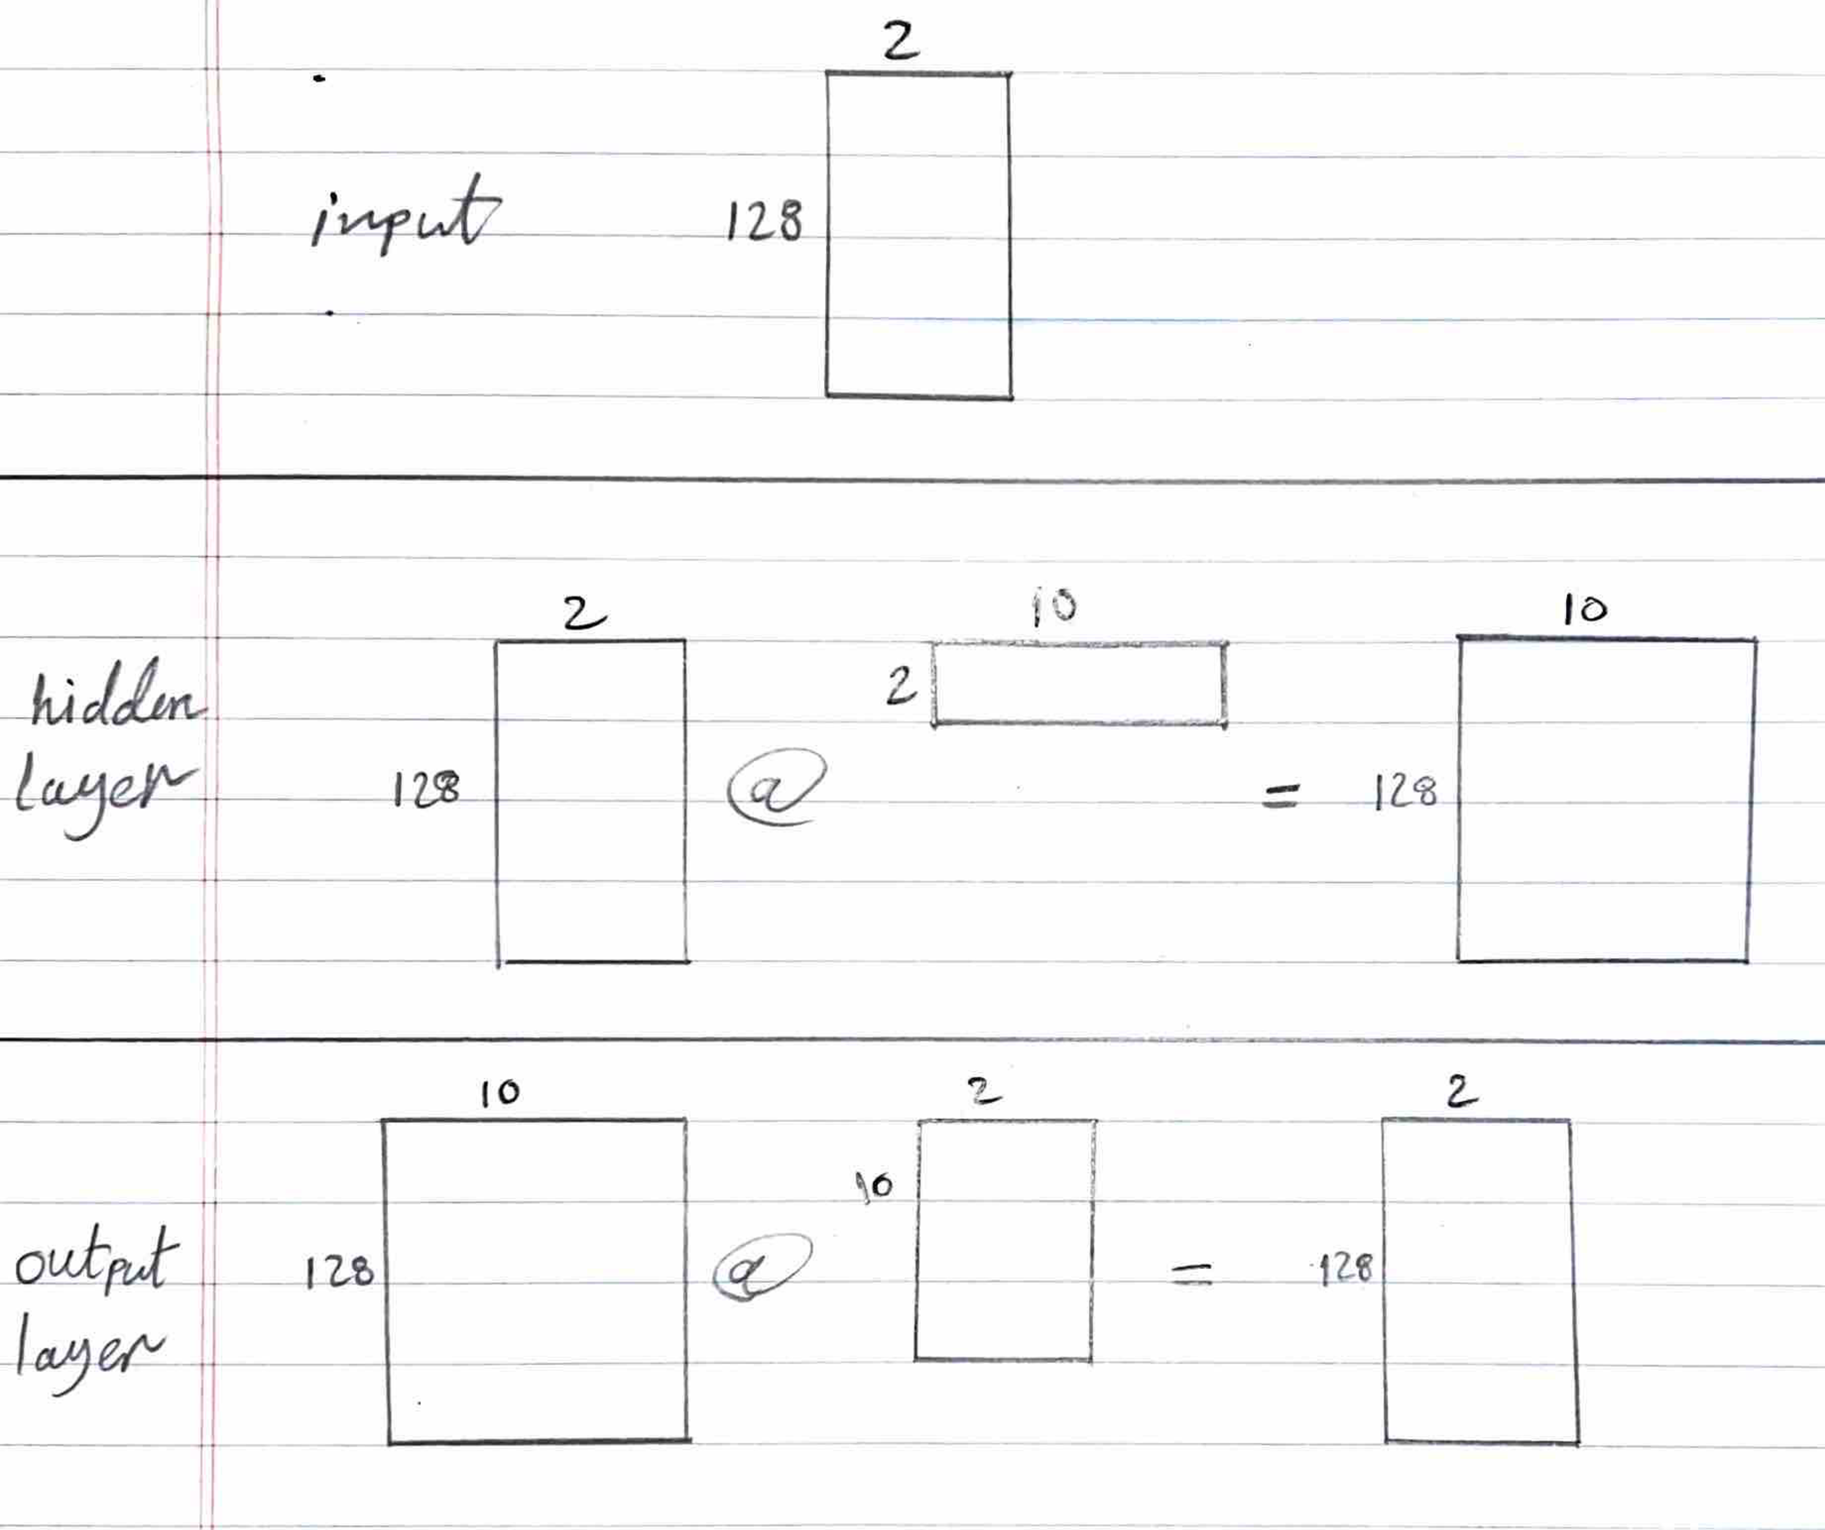

We set the optimizer to adam using `optax` library. Then we initialized the model using random parameters. For the loss function, we used cross entropy to evaluate the model predictions.

In [ ]:
optimizer = optax.adam(learning_rate=0.01)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(SEED), 3)
params = model.init(jax.random.PRNGKey(SEED),
                    jax.random.normal(inp_rng, (BATCH_SIZE, dataset.data.shape[1])))

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

## MLP Training (JIT mode)

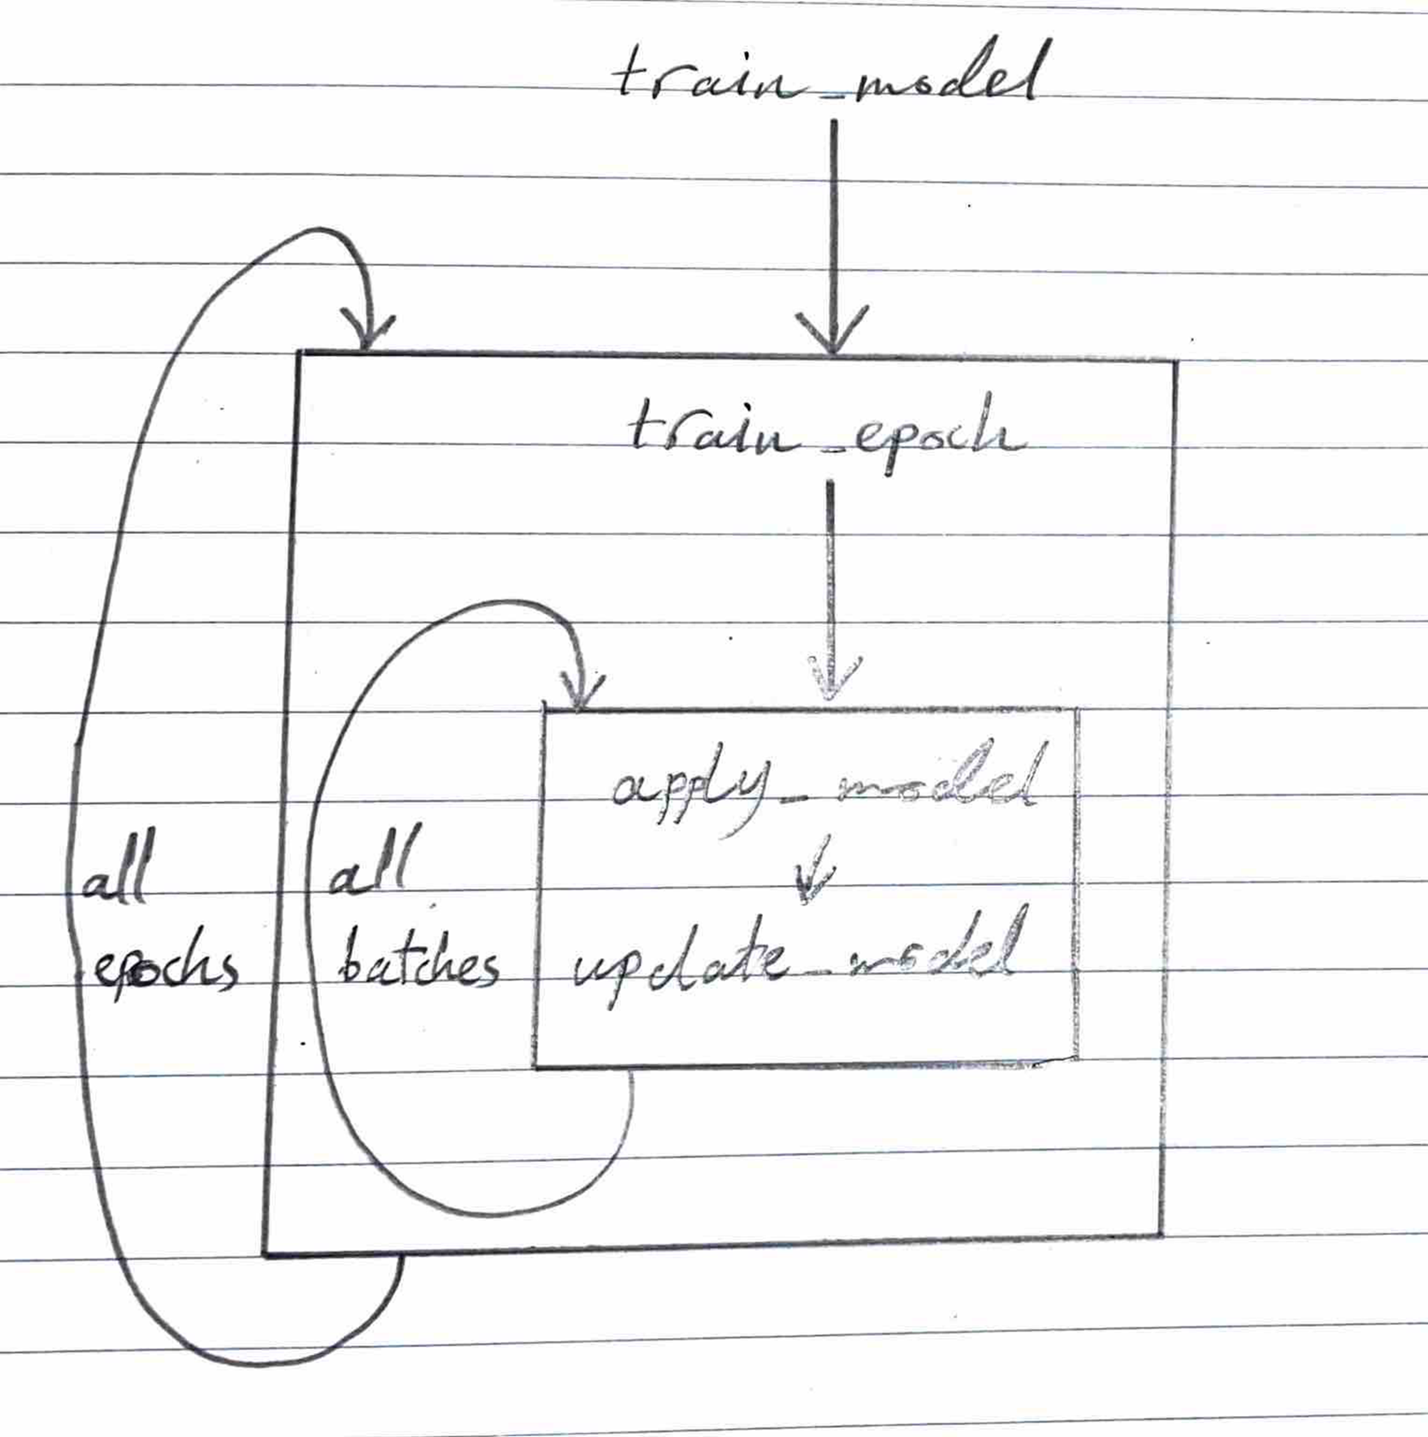

In [ ]:
@jax.jit
def apply_model(state, images, labels):
  """Computes gradients, loss and accuracy for a single batch."""

  def loss_fn(params):
    logits = state.apply_fn(params, images)
    one_hot = jax.nn.one_hot(labels, logits.shape[1])
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return grads, loss, accuracy

@jax.jit
def update_model(state, grads):
  return state.apply_gradients(grads=grads)

def train_epoch(state, data_loader):
  """Train for a single epoch."""

  epoch_loss = []
  epoch_accuracy = []

  for batch in data_loader:
    batch_images, batch_labels = batch
    grads, loss, accuracy = apply_model(state, batch_images, batch_labels)
    state = update_model(state, grads)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy

def train_model(state, train_data_loader, num_epochs):
  # Training loop
  for epoch in range(num_epochs):
    state, train_loss, train_accuracy = train_epoch(state, train_data_loader)
    print(f'epoch: {epoch:03d}, train loss: {train_loss:.4f}, train accuracy: {train_accuracy:.4f}')
  return state

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
func_time = %timeit -o train_model(model_state, train_data_loader, num_epochs=1)

<IPython.core.display.Javascript object>

epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
65.7 ms ± 1.73 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
timing_list.append(['MLP', 'jit', np.mean(func_time.timings), np.std(func_time.timings)])

## MLP Training (no JIT mode)

In [ ]:
def apply_model_no_jit(state, images, labels):
  """Computes gradients, loss and accuracy for a single batch."""

  def loss_fn_no_jit(params):
    logits = state.apply_fn(params, images)
    one_hot = jax.nn.one_hot(labels, logits.shape[1])
    loss = jnp.mean(optax.softmax_cross_entropy(logits=logits, labels=one_hot))
    return loss, logits

  grad_fn = jax.value_and_grad(loss_fn_no_jit, has_aux=True)
  (loss, logits), grads = grad_fn(state.params)
  accuracy = jnp.mean(jnp.argmax(logits, -1) == labels)
  return grads, loss, accuracy

def update_model_no_jit(state, grads):
  return state.apply_gradients(grads=grads)

def train_epoch_no_jit(state, data_loader):
  """Train for a single epoch."""

  epoch_loss = []
  epoch_accuracy = []

  for batch in data_loader:
    batch_images, batch_labels = batch
    grads, loss, accuracy = apply_model_no_jit(state, batch_images, batch_labels)
    state = update_model_no_jit(state, grads)
    epoch_loss.append(loss)
    epoch_accuracy.append(accuracy)
  train_loss = np.mean(epoch_loss)
  train_accuracy = np.mean(epoch_accuracy)
  return state, train_loss, train_accuracy

def train_model_no_jit(state, train_data_loader, num_epochs):
  # Training loop
  for epoch in range(num_epochs):
    state, train_loss, train_accuracy = train_epoch_no_jit(state, train_data_loader)
    print(f'epoch: {epoch:03d}, train loss: {train_loss:.4f}, train accuracy: {train_accuracy:.4f}')
  return state

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
func_time = %timeit -o trained_model_state = train_model_no_jit(model_state, train_data_loader, num_epochs=1)

<IPython.core.display.Javascript object>

epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
epoch: 000, train loss: 0.5810, train accuracy: 0.7098
2.36 s ± 24.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
timing_list.append(['MLP', 'no jit', np.mean(func_time.timings), np.std(func_time.timings)])

## Load CIFAR10 Dataset

In [ ]:
# A helper function that normalizes the images between the values specified by the hyper-parameters.
def image_to_numpy(img):
  img = np.array(img, dtype=np.float32)
  img = (img / 255. - DATA_MEANS) / DATA_STD
  return img

In [ ]:
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')
# images in the test set will only be converted into numpy arrays
test_transform = image_to_numpy
# images in the train set will be randomly flipped, cropped, and then converted to numpy arrays
train_transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomResizedCrop((IMAGE_SIZE, IMAGE_SIZE), scale=CROP_SCALES, ratio=CROP_RATIO),
    image_to_numpy
])

# Validation set should not use train_transform.
train_dataset = torchvision.datasets.CIFAR10('data', train=True, transform=train_transform, download=True)
val_dataset = torchvision.datasets.CIFAR10('data', train=True, transform=test_transform, download=True)
train_set, _ = torch.utils.data.random_split(train_dataset, [45000, 5000], generator=torch.Generator().manual_seed(SEED))
_, val_set = torch.utils.data.random_split(val_dataset, [45000, 5000], generator=torch.Generator().manual_seed(SEED))
test_set = torchvision.datasets.CIFAR10('data', train=False, transform=test_transform, download=True)

train_data_loader = torch.utils.data.DataLoader(
    train_set, batch_size=BATCH_SIZE, shuffle=True, drop_last=True, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)
val_data_loader = torch.utils.data.DataLoader(
    val_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)
test_data_loader = torch.utils.data.DataLoader(
    test_set, batch_size=BATCH_SIZE, shuffle=False, drop_last=False, num_workers=2, persistent_workers=True, collate_fn=numpy_collate,
)

100%|██████████| 170498071/170498071 [00:03<00:00, 53575476.16it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified
Files already downloaded and verified


## CNN

In [ ]:
class CNN(nn.Module):
  """A simple CNN model."""

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(features=32, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = nn.Conv(features=64, kernel_size=(3, 3))(x)
    x = nn.relu(x)
    x = nn.avg_pool(x, window_shape=(2, 2), strides=(2, 2))
    x = x.reshape((x.shape[0], -1))  # flatten
    x = nn.Dense(features=256)(x)
    x = nn.relu(x)
    x = nn.Dense(features=10)(x)
    return x

In [ ]:
model = CNN()

optimizer = optax.adam(learning_rate=1e-4)

rng, inp_rng, init_rng = jax.random.split(jax.random.PRNGKey(SEED), 3)
params = model.init(jax.random.PRNGKey(SEED),
                    jax.random.normal(inp_rng, (BATCH_SIZE, 32, 32, 3)))

model_state = train_state.TrainState.create(apply_fn=model.apply,
                                            params=params,
                                            tx=optimizer)

## CNN Training (JIT mode)

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
func_time = %timeit -o train_model(model_state, train_data_loader, num_epochs=1)

<IPython.core.display.Javascript object>

epoch: 000, train loss: 1.6836, train accuracy: 0.4074
epoch: 000, train loss: 1.6942, train accuracy: 0.3986
epoch: 000, train loss: 1.6877, train accuracy: 0.4070
epoch: 000, train loss: 1.6871, train accuracy: 0.4008
epoch: 000, train loss: 1.6854, train accuracy: 0.4038
epoch: 000, train loss: 1.6895, train accuracy: 0.4048
epoch: 000, train loss: 1.6913, train accuracy: 0.4031
epoch: 000, train loss: 1.6914, train accuracy: 0.4038
7.45 s ± 90.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
timing_list.append(['CNN', 'jit', np.mean(func_time.timings), np.std(func_time.timings)])

## CNN Training (no JIT mode)

In [ ]:
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
func_time = %timeit -o trained_model_state = train_model_no_jit(model_state, train_data_loader, num_epochs=1)

<IPython.core.display.Javascript object>

epoch: 000, train loss: 1.6863, train accuracy: 0.4041
epoch: 000, train loss: 1.6924, train accuracy: 0.4013
epoch: 000, train loss: 1.6858, train accuracy: 0.4047
epoch: 000, train loss: 1.6865, train accuracy: 0.4044
epoch: 000, train loss: 1.6862, train accuracy: 0.4032
epoch: 000, train loss: 1.6871, train accuracy: 0.4038
epoch: 000, train loss: 1.6895, train accuracy: 0.4024
epoch: 000, train loss: 1.6866, train accuracy: 0.4046
29 s ± 401 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [ ]:
timing_list.append(['CNN', 'no jit', np.mean(func_time.timings), np.std(func_time.timings)])

## Plotting the running time

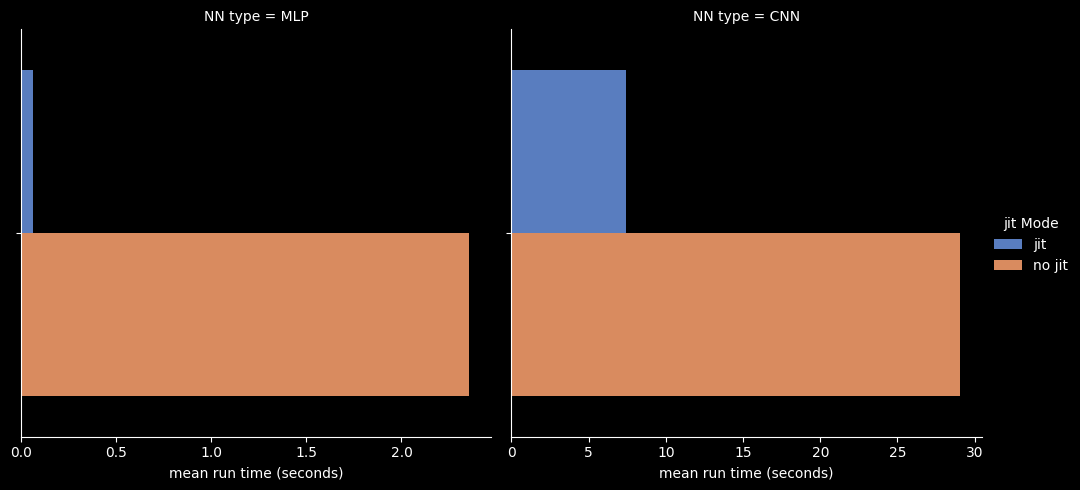

In [ ]:
df = pd.DataFrame(timing_list, columns=('NN type', 'jit Mode', 'mean run time (seconds)', 'std run time (seconds)'))
sns.catplot(df, x='mean run time (seconds)', hue='jit Mode', col='NN type',
            kind='bar', sharex=False, palette="muted")
plt.show()